In [1]:
from __future__ import division
import gensim
import numpy as np
import warnings
import statistics
import os 
from sentence_extracor import segment_sentences_tok
from difflib import SequenceMatcher
from matplotlib import pyplot as plt
from matplotlib.pyplot import hist
from matplotlib.cm import rainbow
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

Loading tokens...
Done!


In [49]:
def get_fasttest_model(path_to_model, path_to_corpus):
    # Load FastText model from path_to_model.
    # If it doesn't exist, train new model on path_to_data and save it to path_to_model
    
    #f = open(path_to_corpus)
    #data = f.read().decode("utf8").lower()
    #f.close()
    tokens = statistics.tokenize_me(path_to_corpus, depth='raw')
    if os.path.isfile(path_to_model):
        print("Model %s exists. Loading..." % (path_to_model))
        return gensim.models.FastText.load(path_to_model), tokens
    print(tokens[:10])
    sents = segment_sentences_tok(tokens)
    model = gensim.models.FastText(size=256, window=3, min_count=2, workers=4) #window=10 window=20
    model.build_vocab(sents)
    print("Trainig of FastText model is started...")
    model.train(sents, total_examples=model.corpus_count, epochs= 50)
    model.save(path_to_model)
    return model, tokens
    
def string_similar(a, b):
    #get string similarity. It is not known whether this is the Levenshtein distance.
    
    return SequenceMatcher(None, a, b).ratio()
    

def matrix_eucl_dist(a,b):
    print("a", a[:10])
    print("b", b[:10])
    c = np.subtract(a, b)
    print("a - b", c[:10])
    c = np.matmul(c,c.transpose())
    print("matmul", c[:10])
    c = np.sum(c, axis=0)
    print("sum", c[:10])
    c = np.sqrt(c)
    print("sqrt", c[:10])
    return c

def get_tsne(arrays, data=None, restrict=1000):
    # arrays: list of numpy arrays
    # data: data for annotate. Need for corrupting words only
    # restrict: restrict nubmer of elements of arrays that will be put in tSNE

    X_emb = []
    for i in arrays:
        X_emb.append(TSNE(n_components=2).fit_transform(i[:restrict]))
    colors = rainbow(np.linspace(0, 1, len(X_emb)))
    for X, c in zip(X_emb, colors):
        plt.scatter(X[:,0], X[:,1], color=c)
    #this module for annotate corrupted words and original
    if data != None:
        for i,word in enumerate(data):
            try:
                plt.annotate(word, X_emb[0][i])
                plt.annotate(corrupt_random_permutation(word), X_emb[1][i])
            except:
                continue
    plt.show()

def corrupt_random_permutation(word):
    index = np.random.randint(0, len(word)-1)
    first = word[index]
    sec = word[index+1]
    return  word[:index] + word[index+1] + word[index] + word[index+2:]

def compute_accuracy(orig, corrected):
    # compute spell correction accuracy
    # input:
    #   orig: list of original words
    #   corrected: list of corrected words
    # return:
    #   correction accuracy by word full match
    res = []
    for i,z in zip(orig, corrected):
        res.append(i == z)
    print(res[:10])
    print(sum(res))
    return sum(res)/len(res)

Tokinization...
Model ./fasttext exists. Loading...
Build word vectors...


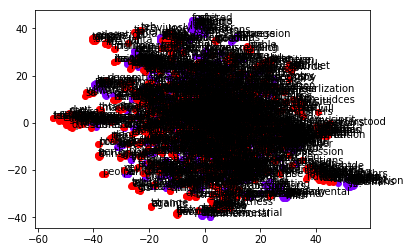

a [[ 0.31102026  0.3509546   0.33062506 ...  0.04906479  0.25338432
   0.07022078]
 [ 0.26194668  0.8668109   1.1962581  ...  0.34566554 -0.2590686
   0.16362871]
 [-0.44401467  0.761598   -0.30338147 ...  0.58422977 -1.3054491
   0.23047175]
 ...
 [-0.10169709  0.7690973  -0.36800483 ...  2.1987784  -1.5589554
   0.01911226]
 [-0.06452963  0.8326585  -0.31546    ...  0.15716352 -0.21687315
   0.09211974]
 [-1.2287205   3.4965043   1.6409243  ...  0.04522556 -1.9787043
  -0.8611774 ]]
b [[ 0.7147349   0.75482607  0.6626774  ... -0.08200347  0.25741985
   0.2786921 ]
 [ 0.26004398  1.6025399   1.564988   ...  0.7830973  -0.37147024
   0.37878746]
 [ 2.0718198   0.7875177   0.02083546 ...  0.19562328  0.7322136
   1.5515623 ]
 ...
 [-1.164155    0.09558523 -1.5294027  ...  1.4896601  -2.2434745
  -0.20553775]
 [ 0.73198205  0.30945677  0.42598593 ...  0.02127692  0.21767065
   0.1203391 ]
 [-0.05521595  0.18466194 -0.24297881 ... -0.0500462  -0.26499805
  -0.42049128]]
a - b [[-4.0371465

/home/astromis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in sqrt


In [3]:
    model, tokens = get_fasttest_model("./fasttext", "./nitshe.txt")
    print("Build word vectors...")
    vectors = list()
    vectors_cor = list()
    entered_words = set()
    for i in tokens:
        if len(i) != 5 and i in entered_words:
            continue
        try:
            vectors_cor.append(model.wv.get_vector(corrupt_random_permutation(i)) ) #* string_similar(i, corrupt(i))
        except:
            continue
        try:
            vectors.append(model.wv.get_vector(i))
        except:
            vectors_cor = vectors_cor[:-1]
            continue
        entered_words.add(i)
        

    vectors = np.stack(vectors, axis=0)
    vectors_cor = np.stack(vectors_cor)
    #matrix_dist = matrix_eucl_dist(vectors, vectors_cor)
    print("Print t-SNE for %d words..." %(len(list(entered_words))))
    get_tsne([vectors, vectors_cor], list(entered_words)) # for right annotating of arrays, a list must have this order

In [55]:
def baseline_spellchecker(model, tokens):
    original = []
    corrected = []
    for i in tokens:
        cor_word = corrupt_random_permutation(i)
        try:
            corrected_ = model.most_similar(cor_word)[0][0]
        except:
            continue
        corrected.append(corrected_)
        original.append(i)
    print(compute_accuracy(original, corrected))
    
baseline_spellchecker(model, entered_words)


/home/astromis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys
/home/astromis/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[False, False, True, False, False, True, False, False, False, False]
1623
0.1508224142737664


'\nfor i in range(10):\n    origin_word = np.random.choice(tokens)\n    print("origin word: ", origin_word)\n    cor_word = corrupt_random_permutation(origin_word)\n    \n    print(cor_word)\n    print(model.similar_by_word(cor_word, topn = 20)[0][0])\n\n#model.keyedvectors.most_similar_to_given("moarlity", ["morality","humility", "utility" ])\nprint(dir(model))\n'